<a href="https://colab.research.google.com/github/ottl-seo/biometric-security/blob/main/ANN_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **단층 신경망**(단층 퍼셉트론)의 구현 사례

## 성능 향상을 위해 변경한 변수들
1. 노드 개수 (num_units): 2,4,6, ...
2. 경사하강법의 학습율(GradientDescentOptimizer): 0.001, 0.0005, ...
3. 반복 횟수: 1000, 4000, ...
4. 은닉계층 활성화 함수: tanh, relu, ...

### 1. 필요한 모듈 불러오기

In [106]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import multivariate_normal, permutation
import pandas as pd
from pandas import DataFrame, Series

### 2. 텐서플로우 버전 낮추기

In [107]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

### 3. 난수의 씨드를 설정

In [108]:
np.random.seed(1971063)
tf.set_random_seed(1971063)

### 4. 학습 데이터 생성하기

In [109]:
def generate_datablock(n, mu, var, t):
  data= multivariate_normal(mu, np.eye(2)*var, n)
  df= DataFrame(data, columns=['x1','x2'])
  df['t'] = t
  return df

df0 = generate_datablock(15, [7,7], 22, 0)
df1 = generate_datablock(15, [22,7], 22, 0)
df2 = generate_datablock(10, [7,22], 22, 0)
df3 = generate_datablock(25, [20,20], 22, 1)

df = pd.concat([df0, df1, df2, df3], ignore_index=True)
train_set = df.reindex(permutation(df.index)).reset_index(drop=True)


### 5. 학습 데이터 확인하기

In [110]:
train_set

,x1,x2,t
0,11.065562,14.362012,0
1,5.756806,14.768169,0
2,7.644161,3.778764,0
3,14.843614,20.527043,1
4,12.366110,23.988449,1
...,...,...,...
60,22.149930,25.916585,1
61,23.271610,14.676548,1
62,15.882002,20.618751,1
63,17.148620,27.460157,1


#### 6. (x1, x2)와 t를 각각 모은 것을 넘파이의 array 오브젝트로 추출해둔다.

In [111]:
train_x = train_set[['x1','x2']].to_numpy()
train_t = train_set['t'].to_numpy().reshape([len(train_set), 1])

### 7. 단층 신경망을 이용한 이항 분류기 모델을 정의한다.
: 가설함수로 단층 신경망 기반 이항 분류기 모델을 정의함.   
#### // *이 부분 제일 중요--*
- **layer** = 4
- **활성화 함수**: tanh 사용

In [112]:
num_units = 4  # 노드 개수: 2
mult = train_x.flatten().mean() # x1,x2의 평균값= mult

x = tf.placeholder(tf.float32, [None, 2])

w1 = tf.Variable(tf.truncated_normal([2, num_units])) # 난수 발생
b1 = tf.Variable(tf.zeros([num_units]))

#hidden1 = tf.nn.relu(tf.matmul(x, w1)+ b1*mult)  #relu로도 해보고
hidden1 = tf.nn.tanh(tf.matmul(x, w1) + b1*mult) # tanh로도 해보기--> 성능 뭐가 더?

w0 = tf.Variable(tf.zeros([num_units, 1]))
b0 = tf.Variable(tf.zeros([1]))
p = tf.nn.sigmoid(tf.matmul(hidden1, w0) + b0*mult) #여기도 mult 곱해주는것...

 *mult 에 대하여--   
 bias는 결국 데이터의 평균값(mult)을 따라가므로, *mult 해준다.
#### --> 파라미터 최적화를 고속화 하기 위한 처리임!

In [113]:
p.shape

TensorShape([Dimension(None), Dimension(1)])

### 8. Loss 함수(비용함수,오차함수), 학습 알고리즘(단계), 정답률 식 정의
* 오차함수: loss
* 트레이닝 알고리즘: train_step
* 정답률 accuracy
####     
 *//여긴 그대로 쓰되,*    
 *//GradientDescentOptimizer(이 부분)만 바꾸기*

#### 경사하강법의 학습율(GradientDescentOptimizer)을 **0.001**로 설정하였다.

In [114]:
t = tf.placeholder(tf.float32, [None, 1])
loss = -tf.reduce_sum(t*tf.log(p) + (1-t)*tf.log(1-p))
train_step = tf.train.GradientDescentOptimizer(0.0005).minimize(loss) # 이 부분
correct_prediction = tf.equal(tf.sign(p-0.5), tf.sign(t-0.5))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### 9. 세션을 준비하고 Variable을 초기화

In [115]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


### 10. 파라미터 최적화를 **1000**회 반복한다.

In [116]:
i = 0
for _ in range(1000): #1000번 반복
  i+=1
  sess.run(train_step, feed_dict={x:train_x, t:train_t}) #feed_dict로 파라미터 넘겨준다!!
  if i % 100 == 0:  ##100번 단위로 출력해준다
    loss_val, acc_val = sess.run(
        [loss, accuracy], feed_dict={x:train_x, t:train_t})
    print('Step: %d, Loss: %f, Accuracy: %f'
    %(i,loss_val, acc_val))  ## 반복횟수,오차,정확도 출력

Step: 100, Loss: 42.999912, Accuracy: 0.615385
Step: 200, Loss: 42.711288, Accuracy: 0.615385
Step: 300, Loss: 41.546951, Accuracy: 0.615385
Step: 400, Loss: 39.501556, Accuracy: 0.615385
Step: 500, Loss: 28.116619, Accuracy: 0.892308
Step: 600, Loss: 20.026134, Accuracy: 0.923077
Step: 700, Loss: 17.180193, Accuracy: 0.923077
Step: 800, Loss: 15.750172, Accuracy: 0.907692
Step: 900, Loss: 14.889032, Accuracy: 0.923077
Step: 1000, Loss: 14.433676, Accuracy: 0.923077


### 11. 얻어진 확률을 색의 농담으로 그림에 표시한다.

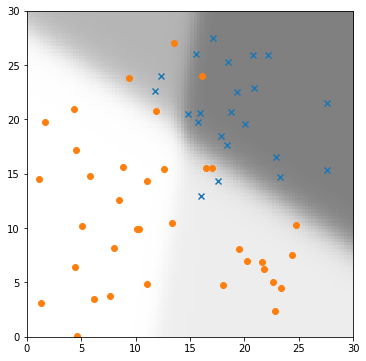

In [117]:
train_set1 = train_set[train_set['t']==1]
train_set2 = train_set[train_set['t']==0]

fig = plt.figure(figsize=(6,6))
subplot = fig.add_subplot(1,1,1)
subplot.set_ylim([0,30])
subplot.set_xlim([0,30])
subplot.scatter(train_set1.x1, train_set1.x2, marker='x')
subplot.scatter(train_set2.x1, train_set2.x2, marker='o')

locations = []
for x2 in np.linspace(0,30,100):
  for x1 in np.linspace(0,30,100):
    locations.append((x1, x2))
p_vals = sess.run(p, feed_dict={x:locations})
p_vals = p_vals.reshape((100,100))
subplot.imshow(p_vals, origin='lower', extent=(0,30,0,30),
               cmap=plt.cm.gray_r, alpha=0.5)

# 결과
**정확도 0.938, 오차 7.00** 정도로 도출
####      
### <변수 설정>
1. 노드 개수 = **4**
2. GradientDescentOptimizer= **0.001**
3. 반복 횟수= 1000
4. **tanh** 함수 사용